In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import scipy.io # needed for older versions of MATLAB files
import numpy as np
import scipy.stats as scstats

import sys
sys.path.append("../neuroprob/")

import neuroprob as mdl
from neuroprob import utils
from neuroprob import GP

import models

import pickle

gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)
dev = 'cpu'


plt.style.use(['paper.mplstyle'])

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [3]:
u = np.load('./data/MN_uall.npy')
rates = 0.3*u**2
tbin = 0.2/1000 # seconds
neurons = rates.shape[1]
T = rates.shape[0]

In [4]:
spktrain = mdl.point_process.gen_IBP(rates.T*tbin)
bin_size = 100 # 20 ms
delta_t, resamples, rc_t, _ = utils.neural.bin_data(bin_size, tbin, spktrain, T, binned=True)

In [8]:
shape = np.ones(neurons)
ISI_dist = mdl.point_process.ISI_gamma(shape, scale=1./shape)

spiketimes = mdl.point_process.gen_IRP(ISI_dist, rates[:, :1].T[None, ...], tbin)

In [9]:
bin_size = 1 # 20 ms
delta_t, resamples, rc_t, _ = utils.neural.bin_data(bin_size, tbin, spiketimes, T, binned=False)

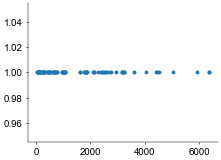

In [13]:
plt.scatter(spiketimes[0][:100], np.ones_like(spiketimes[0][:100]))

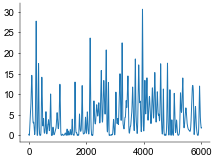

In [14]:
plt.plot(rates[:6000, 0])

### GPyTorch

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

Iter 1/50 - Loss: 0.936   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.904   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.870   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.832   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.790   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.743   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.694   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 0.643   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.595   lengthscale: 0.371   noise: 0.369
Iter 10/50 - Loss: 0.551   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.512   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.475   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.441   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.407   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.375   lengthscale: 0.244   noise: 0.216
Iter 16/50 - Loss: 0.342   lengthscale: 0.234   noise: 0.197
Iter 17/50 - Loss: 0.310   length

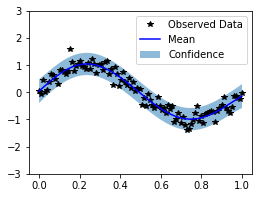

In [7]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

Iter 1/50 - Loss: 123.511
Iter 2/50 - Loss: 119.720
Iter 3/50 - Loss: 115.690
Iter 4/50 - Loss: 111.471
Iter 5/50 - Loss: 107.114
Iter 6/50 - Loss: 102.666
Iter 7/50 - Loss: 98.172
Iter 8/50 - Loss: 93.686
Iter 9/50 - Loss: 89.272
Iter 10/50 - Loss: 85.000
Iter 11/50 - Loss: 80.908
Iter 12/50 - Loss: 76.981
Iter 13/50 - Loss: 73.161
Iter 14/50 - Loss: 69.387
Iter 15/50 - Loss: 65.618
Iter 16/50 - Loss: 61.835
Iter 17/50 - Loss: 58.030
Iter 18/50 - Loss: 54.204
Iter 19/50 - Loss: 50.363
Iter 20/50 - Loss: 46.521
Iter 21/50 - Loss: 42.695
Iter 22/50 - Loss: 38.904
Iter 23/50 - Loss: 35.174
Iter 24/50 - Loss: 31.532
Iter 25/50 - Loss: 28.005
Iter 26/50 - Loss: 24.623
Iter 27/50 - Loss: 21.412
Iter 28/50 - Loss: 18.399
Iter 29/50 - Loss: 15.605
Iter 30/50 - Loss: 13.046
Iter 31/50 - Loss: 10.730
Iter 32/50 - Loss: 8.657
Iter 33/50 - Loss: 6.825
Iter 34/50 - Loss: 5.227
Iter 35/50 - Loss: 3.857
Iter 36/50 - Loss: 2.714
Iter 37/50 - Loss: 1.804
Iter 38/50 - Loss: 1.136
Iter 39/50 - Loss: 0.7

NameError: name 'dev' is not defined

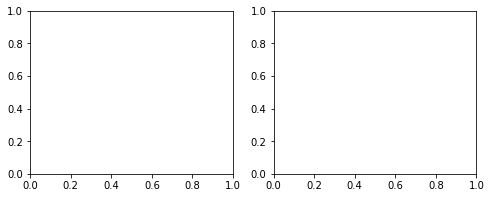

In [3]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood)

train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
    
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).to(dev)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

with torch.no_grad():
    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')

    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')

In [ ]:
plt.plot(model.X.detach().numpy())
#plt.plot(ang)
plt.show()

Number of sampled arrivals: 28


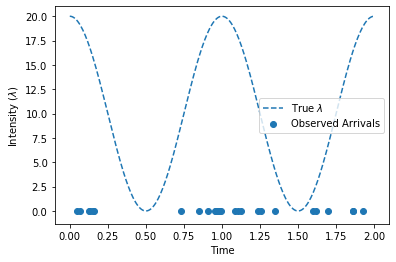

In [1]:
%load_ext autoreload
%autoreload 2

import math
import torch
import gpytorch
import pyro
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

intensity_max = 20
true_intensity_function = lambda times: torch.cos(times * 2 * math.pi).add(1).mul(intensity_max / 2.)

max_time = 2
quad_points = 256

times = torch.linspace(0, max_time, quad_points)
num_samples = int(pyro.distributions.Poisson(true_intensity_function(times).mean() * max_time).sample().item())
print(f"Number of sampled arrivals: {num_samples}")

def log_prob_accept(val):
    intensities = true_intensity_function(val)
    res = torch.log(intensities / (true_intensity_function(times).mean() * max_time))
    return res

arrival_times = pyro.distributions.Rejector(
    propose=pyro.distributions.Uniform(times.min(), times.max()),
    log_prob_accept=log_prob_accept,
    log_scale=0.
)(torch.Size([num_samples]))

fig, ax = plt.subplots(1, 1)
ax.plot(times, true_intensity_function(times), "--", label=r"True $\lambda$")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
ax.legend(loc="best")

class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_arrivals, max_time, num_inducing=32, name_prefix="cox_gp_model"):
        self.name_prefix = name_prefix
        self.max_time = max_time
        self.mean_intensity = (num_arrivals / max_time)

        # Define the variational distribution and strategy of the GP
        # We will initialize the inducing points to lie on a grid from 0 to T
        inducing_points = torch.linspace(0, max_time, num_inducing).unsqueeze(-1).squeeze(0)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution)

        # Define model
        super().__init__(variational_strategy=variational_strategy)
        
        batch_shape = torch.Size([1])

        # Define mean and kernel
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=batch_shape), batch_shape=batch_shape)

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, arrival_times, quadrature_times):
        # Draw samples from q(f) at arrival_times
        # Also draw samples from q(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_guide(torch.cat([arrival_times, quadrature_times], -1))
            )

    def model(self, arrival_times, quadrature_times):
        pyro.module(self.name_prefix + ".gp", self)

        # Draw samples from p(f) at arrival times
        # Also draw samples from p(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                self.pyro_model(torch.cat([arrival_times, quadrature_times], -1))
            )

        ####
        # Convert function samples into intensity samples, using the function above
        ####
        intensity_samples = function_samples.exp() * self.mean_intensity

        # Divide the intensity samples into arrival_intensity_samples and quadrature_intensity_samples
        arrival_intensity_samples, quadrature_intensity_samples = intensity_samples.split([
            arrival_times.size(-1), quadrature_times.size(-1)
        ], dim=-1)

        ####
        # Compute the log_likelihood, using the method described above
        ####
        arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
        est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.max_time)
        log_likelihood = arrival_log_intensities - est_num_arrivals
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood)

In [7]:
model = GPModel(arrival_times.numel(), max_time)
quadrature_times = torch.linspace(0, max_time, 256)

# this is for running the notebook in our testing framework
num_iter = 400
num_particles = 1


def train(lr=0.01):
    pyro.clear_param_store()
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=False, retain_graph=True)
    infer = pyro.infer.SVI(model.model, model.guide, optimizer, loss=loss)

    model.train()
    loader = tqdm(range(num_iter))
    for i in loader:
        loss = infer.step(arrival_times, quadrature_times)
        loader.set_postfix(loss=loss)

train()

In [9]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

torch.Size([1000, 1, 256])


ValueError: Input passed into argument "'y1'"is not 1-dimensional.

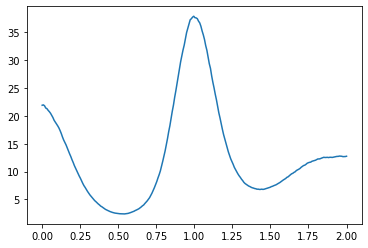

In [10]:
# Get the average predicted intensity function, and the intensity confidence region
model.eval()
with torch.no_grad():
    function_dist = model(quadrature_times)
    intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity
    print(intensity_samples.shape)
    lower, mean, upper = percentiles_from_samples(intensity_samples)

# Plot the predicted intensity function
fig, ax = plt.subplots(1, 1)
line, = ax.plot(quadrature_times, mean[0], label=r"Pred. $\lambda$")
ax.fill_between(quadrature_times, lower, upper, color=line.get_color(), alpha=0.5)
ax.plot(quadrature_times, true_intensity_function(quadrature_times), "--", color="k", label=r"True $\lambda$")
ax.legend(loc="best")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")

KeyboardInterrupt: 

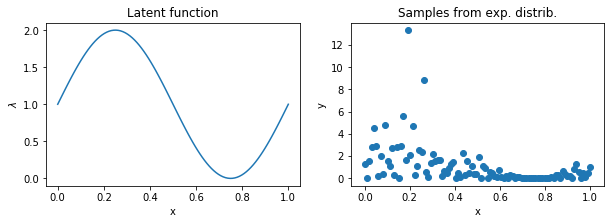

In [1]:
import math
import torch
import gpytorch
import pyro
import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2 * math.pi * x) + 1

# Generate synthetic data
# here we generate some synthetic samples
NSamp = 100

X = np.linspace(0, 1, NSamp)

fig, (lambdaf, samples) = plt.subplots(1, 2, figsize=(10, 3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros_like(X)
for i,x in enumerate(X):
    Y[i] = np.random.exponential(scale(x), 1)
samples.scatter(X,Y)
samples.set_xlabel('x')
samples.set_ylabel('y')
samples.set_title('Samples from exp. distrib.')

train_x = torch.tensor(X).float()
train_y = torch.tensor(Y).float()

class PVGPRegressionModel(gpytorch.Module):
    def __init__(self, num_inducing=64, name_prefix="mixture_gp"):
        gpytorch.Module.__init__(self)
        self.name_prefix = name_prefix

        # Define all the variational stuff
        inducing_points = torch.linspace(0, 1, num_inducing)
        self.variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        )

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def __call__(self, inputs, prior=False, **kwargs):
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(-1)
        return self.variational_strategy(inputs, prior=prior)
        
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def pyro_guide(self, input, beta=1.0, name_prefix=""):
        # Inducing values q(u)
        with pyro.poutine.scale(scale=beta):
            pyro.sample(name_prefix + ".u", self.variational_strategy.variational_distribution)

        # Draw samples from q(f)
        function_dist = self(input, prior=False)
        #function_dist = pyro.distributions.Normal(loc=function_dist.mean, scale=function_dist.stddev).to_event(1)
        return pyro.distributions.Normal(loc=function_dist.mean, scale=function_dist.stddev).to_event(len(function_dist.event_shape) - 1).mask(False)
        #return pyro.distributions.MultivariateNormal(function_dist.mean, \
        #                                             covariance_matrix=function_dist.covariance_matrix)#.to_event(1)#function_dist.mask(False)

    def pyro_model(self, input, beta=1.0, name_prefix=""):
        # Inducing values p(u)
        with pyro.poutine.scale(scale=beta):
            u_samples = pyro.sample(name_prefix + ".u", self.variational_strategy.prior_distribution)

        # Include term for GPyTorch priors
        log_prior = torch.tensor(0.0, dtype=u_samples.dtype, device=u_samples.device)
        for _, prior, closure, _ in self.named_priors():
            log_prior.add_(prior.log_prob(closure()).sum().div(self.num_data))
        pyro.factor(name_prefix + ".log_prior", log_prior)

        # Include factor for added loss terms
        added_loss = torch.tensor(0.0, dtype=u_samples.dtype, device=u_samples.device)
        for added_loss_term in self.added_loss_terms():
            added_loss.add_(added_loss_term.loss())
        pyro.factor(name_prefix + ".added_loss", added_loss)

        # Draw samples from p(f)
        function_dist = self(input, prior=True)
        return pyro.distributions.Normal(loc=function_dist.mean, scale=function_dist.stddev).to_event(len(function_dist.event_shape) - 1).mask(False)
        #return pyro.distributions.MultivariateNormal(function_dist.mean, \
        #                                             covariance_matrix=function_dist.covariance_matrix)#.to_event(1)#function_dist.mask(False)

    
    def guide(self, b):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(self.x[b])

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, b):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(self.x[b])

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)

            # Use the link function to convert GP samples into scale samples
            scale_samples = function_samples.exp()

            # Sample from observed distribution
            pyro.sample(
                self.name_prefix + ".y",
                pyro.distributions.Exponential(scale_samples.reciprocal()),  # rate = 1 / scale
                obs=self.y[b]
            )
            
    def preprocess(self, x, y):
        self.x = x
        self.y = y
        self.batches = len(x)
            
    def fit(self):
        # this is for running the notebook in our testing framework
        num_iter = 200
        num_particles = 1024

        pyro.clear_param_store()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=0.005)
        loss_fn = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True).differentiable_loss
        #loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
        losses = []
        num_iter = 1000
        intv = 50
        iterator = tqdm.autonotebook.tqdm(range(num_iter))
        for i in iterator:
            for b in range(self.batches):
                optimizer.zero_grad()
                loss = loss_fn(self.model, self.guide, b)
                loss.backward(retain_graph=True)
                optimizer.step()

            iterator.set_postfix(loss=loss)
            losses.append(loss.item())
        
model = PVGPRegressionModel()
model.preprocess(torch.split(train_x, 100), torch.split(train_y, 100))
model.fit()

"""
def train():
    optimizer = pyro.optim.Adam({"lr": 0.01})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.tqdm(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss, lengthscale=model.covar_module.base_kernel.lengthscale.item())

%time train()"""

torch.Size([1000, 200])


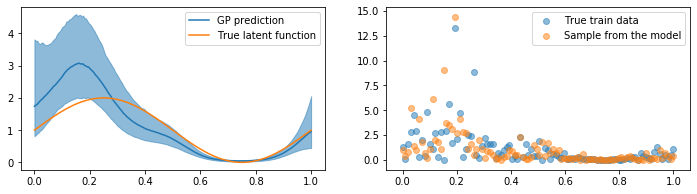

In [7]:
#plt.plot(losses)
#plt.show()

# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, denser * NSamp).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000])).exp()
lower, mean, upper = percentiles_from_samples(samples)
print(samples.shape)

# Draw some simulated y values
scale_sim = model(train_x)().exp()
y_sim = pyro.distributions.Exponential(scale_sim.reciprocal())()

# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean.detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower.detach().cpu().numpy(),
    upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, scale(test_x), label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()